# DRL for Cartpole, tensorflow

Setting up DRL training for Cartpole - this is not a full DQN, but much simplified!
Using tensorflow (transferred from the pytorch variant with the help of Copilot).


## 1. Setting up python environment

In [1]:
import math, random
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, Input

import gymnasium as gym

env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]  # For Atari games, when using RAM states this should be 128 for RAM
action_size = env.action_space.n            # Should be 6 for Pong

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Use Cuda</h3>

In [3]:
#USE_CUDA = tf.config.list_physical_devices('GPU')  # Check if GPU is available
#def Variable(*args, **kwargs):
#    return tf.convert_to_tensor(*args, **kwargs)

## A Simple Neural Network as a Q-Function

Setting up the Deep Q-Network as an action-value function. It provides for each possible action an estimated value for an additionally given state. An get_action method selects an action greedily.

In [ ]:
class DQN(Model):
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.99):
        super(DQN, self).__init__()
        self.model = tf.keras.Sequential([
            Input(shape=(state_size,)),
            #layers.LayerNormalization(axis=-1),  # Normalize inputs, can help stabilize, but trains slower
            layers.Dense(128, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(action_size)  # No activation for Q-values
        ])
        #    layers.LayerNormalization(axis=-1),  # Normalize inputs
        # Using a simpler optimizer helps in stabilizing, in particular as we are using a batch size of 1
        self.optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        #tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate) #tf.keras.optimizers.Adam(learning_rate=learning_rate)

        self.gamma = gamma
        self.loss_fn = tf.keras.losses.MeanSquaredError()

    def call(self, x, training=False):
        # Ensure the model can handle training/evaluation modes properly
        return self.model(x, training=training)

    def get_action(self, state, action_space):
        """
        Select an action using a greedy policy, sometimes.
        :param state: Current state (numpy array or tensor).
        :param action_space: Action space of the environment for random actions.
        :return: Selected action.
        """
        if random.randint(1, 10) == 1:
            # Random action (exploration)
            return action_space.sample()
        else:
            # Greedy action (exploitation)
            state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)  # Add batch dimension
            q_values = self.model(state_tensor, training=False)  # Use the model directly
            return tf.argmax(q_values, axis=1).numpy()[0]

    @tf.function
    def train_step(self, state, action, reward, next_state, done):
        # Add batch dimensions to state and next_state
        state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)  # Shape: (1, state_size)
        next_state_tensor = tf.convert_to_tensor([next_state], dtype=tf.float32)  # Shape: (1, state_size)

        with tf.GradientTape() as tape:
            # Compute next Q-value
            #next_q_value = tf.reduce_max(self(next_state_tensor), axis=1)
            next_q_value = tf.reduce_max(self.model(next_state_tensor))
            #target_q_value = reward_tensor + self.gamma * next_q_value * (1.0 - done_tensor)
            target_q_value = reward + self.gamma * next_q_value * (1 - tf.convert_to_tensor([done], dtype=tf.float32))

            # Compute Q-values
            q_values = self.model(state_tensor)
            q_value = tf.gather_nd(q_values, [[0, action]])  # Index by action
            
            # Compute loss
            loss = self.loss_fn(target_q_value, q_value)

        # Compute and apply gradients (backprop)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return loss

### Visualize training

In [4]:
def plot_dqn_learning(env_steps, rewards):
    clear_output(True)
    plt.figure(figsize=(12, 6))
    plt.title('Environment Steps: %s. - Reward: %s' % (env_steps[-1], np.mean(rewards[-10:])))
    plt.plot(env_steps, rewards, label="Rewards")
    plt.xlabel("Environment Steps")
    plt.ylabel("Rewards")
    plt.legend()
    plt.show()

---

## Training run

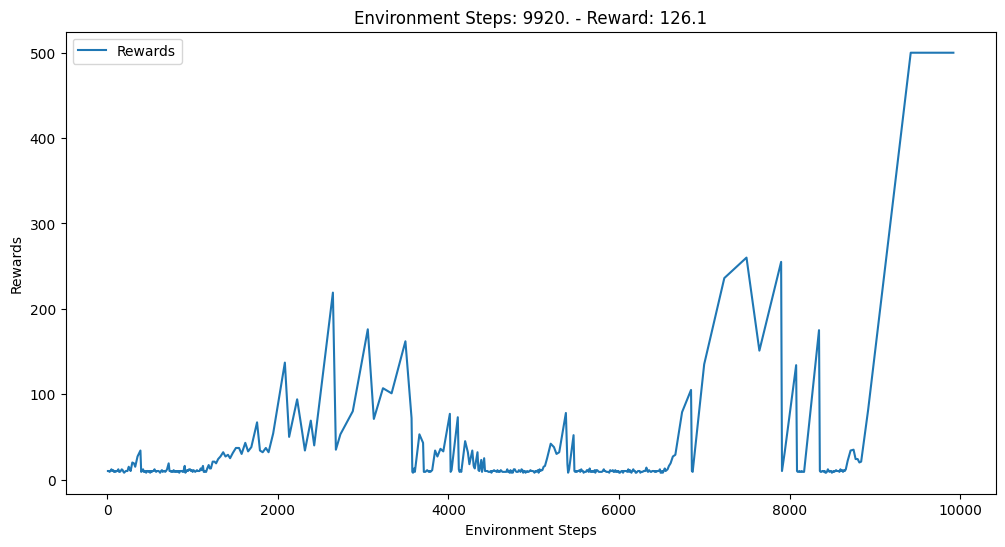

In [7]:
# Training parameters
gamma = 0.99
total_steps = 10_000 

learning_rate = 0.001  # 0.001, for more complex tasks as Atari games, should be much smaller 

# Initialize the Q-network
q_net = DQN(state_size, action_size, learning_rate=learning_rate, gamma=gamma) # Online network

print("Q-networks and optimizer are set up.")

# Check for GPU availability
#USE_CUDA = len(tf.config.list_physical_devices('GPU')) > 0
#device = '/GPU:0' if USE_CUDA else '/CPU:0'
#if USE_CUDA:
#    print("Model will use GPU.")

# Initialize reward and environment step tracking, only for visualization
dqn_all_rewards = []
dqn_total_env_steps = []  # Track environment steps
dqn_episode_reward = 0

state, _ = env.reset()
# Training loop
for step in range(1, total_steps + 1):
    # Select an action from the q-net
    action = q_net.get_action(state, env.action_space)

    # Apply the action in the environment
    next_state, reward, terminated, truncated, _ = env.step(action)
    
    # We don't care how the enviromnet terminated
    done = terminated or truncated

    # Accumulate reward for the current episode
    # only for data collection
    dqn_episode_reward += reward

    # Perform a training step
    with tf.device('/CPU:0'):
        q_net.train_step(state, action, reward, next_state, done)

    # Reset environment if episode ends
    if done:
        state, _ = env.reset()
        dqn_all_rewards.append(dqn_episode_reward)  # Track episode reward
        dqn_total_env_steps.append(step)  # Track total steps at episode end
        dqn_episode_reward = 0  # Reset for next episode
    else:
        state = next_state

    # Plot rewards and episode lengths periodically
    if (step > 500) and step % 1000 == 0:  # Plot every 2 episodes
        plot_dqn_learning(dqn_total_env_steps, dqn_all_rewards)


In [8]:
import ale_py
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time, sys

# Function to play the game and visualize
def play_game_with_model(env_vis, q_net, preprocess_fn=None):
    """
    Let the trained Q-network play the game and visualize it in a notebook.
    As this can cause problems, added exception handling.
    
    :param env_vis: Cartpole environment for visualization.
    :param q_net: Trained Q-network.
    :param preprocess_fn: Optional preprocessing function for frames.
    """
    state, _ = env_vis.reset()
    done = False
    total_reward = 0  # Track the cumulative reward

    try:
        while not done:
            action = q_net.get_action(state, env.action_space)
            # Take the action in the environment
            next_state, reward, terminated, truncated, _ = env_vis.step(action)
            done = terminated or truncated

            # Accumulate the reward
            total_reward += reward

            # Advance state, preprocessing would be integrated
            state = next_state

            # Render the environment
            frame = env_vis.render()
            plt.imshow(frame)
            plt.axis("off")
            clear_output(wait=True)
            plt.pause(0.02)


    except KeyboardInterrupt:
        print("\nVisualization stopped")

    finally:
        env_vis.close()
        print(f"Total Reward: {total_reward}")


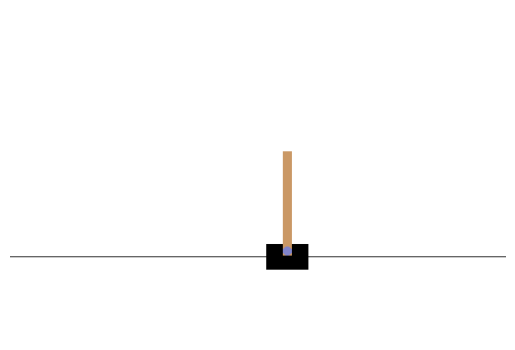

Total Reward: 500.0


In [9]:
env_vis = gym.make("CartPole-v1", render_mode="rgb_array")
play_game_with_model(env_vis, q_net)